# Computer Vision Recap - Segmentation

## Lecture 13: Isotropic Nonlinear Diffusion

### Isotropic Nonlinear Diffusion


Avoid drawbacks of linear diffusion: delocalisation and blurring of edges
$$ \partial_t u = div( g(|\nabla u|^2) \; \nabla u ) $$

Diffusivity $g(|\nabla u|^2) := \frac{1}{1+|\nabla u|^2/\lambda^2}$ decreasing in $|\nabla u|^2$ 


<img src="./images/isodiff.png" width=600>
<br>

- Forward diffusion if $\Phi'(u_x) > 0$ for $|\nabla u| < \lambda$
- Backward diffusion if $\Phi'(u_x) < 0$ for $|\nabla u| > \lambda$

### Regularised Nonlinear Diffusion

- Reduce staircasing artifacts and problems with noise

$$ \partial_t u = div( g(|\nabla u_\sigma|^2) \; \nabla u ) $$ with $$ u_\sigma = K_\sigma*u $$

<br>

Theoretical Results

- Stability under perturbations of initial image
- Preservation of average grey value
- Maximum-minimum principle
- Stable
- Image converges to average grey level

<br><br>
## Lecture 14: Anisotropic Nonlinear Diffusion

**Motivation**
- Isotropic nonlinear diff. have difficulties with noisy images and cannot enhance coherent flow-like structures
- We want to smooth only along edge directions but no across. 

<br>

### Edge-enhancing Anisotropic Diffusion (EED)

**Goal**
- Smooth prefently within regions
- Inhibit diffusion perpendicular to edges

$$ D(\nabla u_\sigma) = (v_1 \;\; v_2) \begin{bmatrix} \lambda_1&0\\0&\lambda_2 \end{bmatrix} (v_1 \;\; v_2)^\top = \lambda_1 v_1 v_1^\top + \lambda_2 v_2 v_2^\top $$

- $\lambda_1 = g(|\nabla u|^2)$ (diffusion across edge), $v_1 \parallel \nabla u_\sigma$
- $\lambda_2 = 1$ (diffusion along edge), $v_2 \perp \nabla u_\sigma$ 

<img src="./images/EED.png" width=300>

<br>

**Problems**:
- Large convolution kernels cancel adjacent gradients with the same direction but opposite orientation
- EED is not good for closing interrupted lines

**Analysing Local Structure**
- small $\sigma$: sensitive to noise
- big $\sigma$: cancellation of adjacent gradients with opposite directions

<br>

### Coherence-Enhancing Anisotropic Diffusion (CED)

Smooth only along the edges: $(\mu_1-\mu_2)^2 >> 0$, but not when we have corners or flat areas ($\mu_1\approx\mu_2$)

basically a 1-D smoothing along flow-like structures

- smooth mainly along coherent structures (i.e. along $v_2 \perp \nabla u_\sigma$)
- increase smoothing with coherence $(\mu_1-\mu_2)^2$ 

**Choice of Diffusion Tensor $D(J_\rho)$**

Coherence (anisotropy) $c=(\mu_1-\mu_2)^2$ are useful to analyse the gradient covariance (how allongated is the covariance?)

- eigenvectors from $J_\rho(\nabla u_\sigma) = K_\rho * (\nabla u_\sigma \nabla u_\sigma^\top)$
- Across coherent structures: $\lambda_1 := \alpha (small \; \alpha >0)$ 
- Along coherent structures: $\lambda_2 := \alpha + (1-\alpha) \exp( \frac{-C}{(\mu_1-\mu_2)^2} )$ 

<img src="./images/CEAD.png" width=300>


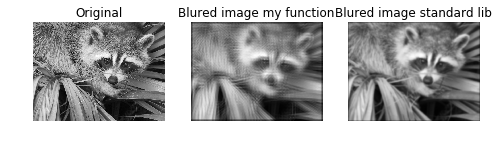

In [15]:
import numpy as np
from scipy import signal, misc, ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def gaussian_filter( img, sigma=1, precision=3, h=1):
    
    length = np.max( [1, np.ceil(precision*sigma/h).astype('int') ])

    gK = np.zeros(np.array([length,length])*2+1)
    for ix in range(length):
        for iy in range(length):
            d = np.linalg.norm([ix,iy]) * h
            gK[ix][iy] = gK[-ix][iy] = gK[ix][-iy] = gK[-ix][-iy] = 1/(sigma*np.sqrt(2*np.pi)) * np.exp( -0.5 * (d/sigma)**2 )
    gK /= gK.sum()

    return signal.convolve2d(img, gK, boundary='fill', mode='same')


def CEAD(img,sigma=1,tau=0.1,hx=1,hy=1):
    ''' Coherence-Enhancing Anysotropic Diffusion'''

    return signal.convolve2d(img, kernel, boundary='fill', mode='same')


''' MAIN '''
sigma = 5

# img = mpimg.imread('./images/sbrain.pgm') 
img = misc.face(gray=True).astype(np.float32)
img_g1 = gaussian_filter(img, sigma=sigma, precision=3, h=1)
img_g2 = ndimage.gaussian_filter(img, sigma=sigma, mode='constant')


fig, (ax_orig, ax_conv1, ax_conv2) = plt.subplots(1,3, figsize=(8,10))
ax_orig.imshow(img, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_conv1.imshow(img_g1, cmap='gray')
ax_conv1.set_title('Blured image my function')
ax_conv1.set_axis_off()
ax_conv2.imshow(img_g2, cmap='gray')
ax_conv2.set_title('Blured image standard lib')
ax_conv2.set_axis_off()
fig.show()

<br><br>
## Lecture 15: Mumford-Shah Model (Segmentation)



### Mumford-Shah Model

Seeks segmentation (u,K) of some initial image $f:\Omega\rightarrow \mathbb R$ as the minimizer of

$$ E_{MS}(u,K) = \int_\Omega (u-f)^2 dx dy + \alpha \int_{\Omega\backslash K} |\nabla u|^2 dx dy + \lambda l(K)$$

- matematically extremely challenging
- rewards homogeneity within each region
- allows edges between regions
- encourages small length of segmentation boundaries

<br>

### Mumford-Shah Cartoon Model

Approximation for $\alpha\rightarrow \infty$:
$$ E_{MS}(u,K) = \int_\Omega (u-f)^2 dx dy + \lambda l(K)$$

which is sufficient to control the homogeneity within each segment and also minimize the length of the boundaries

#### Approximation method for minimization

A segmentation $K$ is called **2-normal** if every segmentation $K'$, that results from merging two neighbouring segments of $K$ has a larger energy:
$$E(K') > E(K)$$
This means a 2-normal segmentation is a local minimum

**Idea:** approximate global minimiser of cartoon model by local minimiser resulting from the restriction to 2-normal segmentations. Create 2-normal segmentations by region merging

Merging two regions yields:
$$ E(K\backslash \partial(\Omega_i,\Omega_j)) = E(K) + \frac{|\Omega_i|\cdot |\Omega_j|}{|\Omega_i|+|\Omega_j|} (u_i-u_j)^2  - \lambda l(\partial (\Omega_i,\Omega_j))$$

Solving $E(K\backslash \partial(\Omega_i,\Omega_j)) - E(K) = 0$ yields:
$$ \lambda_{i,j} = \frac{ \frac{|\Omega_i|\cdot |\Omega_j|}{|\Omega_i|+|\Omega_j|} (u_i-u_j)^2 }{l(\partial (\Omega_i,\Omega_j))} $$

<br>

### The Ambrosio-Tortorelli Mode



Approximation of the Mumford-Shah functional by:
$$ E_{MS-AT}(u,v) := \int_{\Omega} \left(  (u-f)^2 + \alpha\cdot v^2\cdot |\nabla u|^2 + \beta\cdot \left(c|\nabla v|^2+\dfrac{(1-v)^2}{4c}\right)  \right) dx dy$$

where v(x,y) is an edge indicator function ($v\rightarrow 0$ at edges and 1 within region)

- **Advantage**: smooth unkown function $v$ is mathm. more convenient than an unkown edge set $K$ 

<br>

Solving with Euler-Lagrange equations yields:
$$ 0 = \frac{1}{\alpha} (u-f) - div(v^2 \nabla u) $$
$$ 0 = \frac{\alpha}{\beta} v |\nabla u|^2 - \frac{1-v}{4c} - c\Delta v $$ 

with boundary conditions:
$$ 0 = n \cdot \nabla u \quad \quad 0=n\cdot\nabla v  $$

<br>

- The MS-AT energy is not jointly convex in $(u,v)$ and therefore may have multiple minima
- Consequently, the diffusion-reaction system may get stuck in a local minima

<br>

The Ambrosio-Tortorelli are related to the Perona-Malik (nonlinear isotropic diffusion) filter

## Lecture 16: Continuous Scaled Morphology, Schock Filters

### Classical Morphology

Typical structuring elements B: discs,s squares of ellipses

- Dilation: $(f \oplus B) (x) := \sup \{ f(x-y) | y \in B \}$
- Erosion: $(f\ominus B)(x) := \inf \{  f(x+y) | y \in B \}$
- Opening:  $(f \circ B)(\boldsymbol{x}):=((f \ominus B) \oplus B)(\boldsymbol{x})$ 
- Closing: $(f \bullet B)(\boldsymbol{x}):=((f \oplus B) \ominus B)(\boldsymbol{x})$

<br>

### Morphological Curve Evolution

Consider a binary image object with boundary curve $c_0 = (x(p),y(p))$

- Dilate with a disc-shaped structuring elements of continuously increasing radius t. Then the resulting curve c(t) follows the evolution (propagation in outer normal direction)
$$ \partial_t c = n$$

- Erosion it with a disc-shaped propagates in inner normal direction normal 
$$ \partial_t c = -n  $$

where $n=\frac{\nabla u}{|\nabla u|}$ and with initial condition $c(o)=c_0$

<br>

### From curve evolution to image evolution

Consider some curve evolution with speed function $\beta$ depending on the curvature $\kappa$
$$ \partial_t c = \beta(\kappa) \cdot n $$

<br> 

Level set: embed $c$ as a level line into some smooth scalar-valued image $u$, using the **signed distance function**:

$$u(\boldsymbol{x}, t):=\left\{\begin{aligned} \operatorname{dist}(\boldsymbol{x}, \boldsymbol{c}(t)) &\quad (\boldsymbol{x} \text { inside } \boldsymbol{c}) \\-\operatorname{dist} (\boldsymbol{x}, \boldsymbol{c}(t)) & \quad (\mathrm{else}) \end{aligned}\right.$$

Then the zero crossing of $u$ are given by: $$ u(c,t)=0 $$

<img src="./images/curveevo.png" width=600>

<br>

**Main result:** Curve evolution $\partial_t c = \pm n$ leads to image evolutions $\partial_t u = \pm |\nabla u|$. (+ for dilation, - for erosion)

<img src="./images/dilationerosion.png" width=400>



<br>

### Shock Filtering

- Mercury Dilation around maxima (regions where $\Delta u < 0$)
- Erosion around minima (regions where $\Delta u > 0$)

Shock equation:
$$ \partial_t u = -sgn(\Delta u) \; |\nabla u| $$

Create shock at edge locations where $\Delta u=0$


<img src="./images/shockfilter.png" width=400>

<br><br>

### Coherence enhancing shock filter:
$$ \partial_t u = -sgn(u_{ww}) \; |\nabla u| $$
where $w$ is the normalised dominant eigenvector of the structure tensor $J_\rho(\nabla u)$ 
